# Scatter plot of pixel intensity values

In [1]:

%load_ext autoreload
%autoreload 2

from src.data import utils
from src.models.data import *
from src.models.predict_model import *
from src.visualization.visualize import *

from pathlib import Path
import os, shutil
import sys
import time
%matplotlib inline

Using TensorFlow backend.


## User settings

In [2]:
# paths to append
sys.path.append("/home/ubuntu/roaddetection/")
sys.path.append("/media/hh/hd_internal/hh/DSR_Berlin_2018/roaddetection/")

# base directory with data (image tiles) to be analyzed
# dir_eval = "../../data/validate"
dir_eval = "../../data/train"
# subdirs
dir_x = 'sat'
dir_y = 'map'

# ------------- image characteristics -----------------------------
# size of tiles
target_size = (512,512)

# ------------- selection of samples -----------------------------
if True:
    # set *number* of samples (files) to analyze and let selection proceed 
    num_x = 3
    mode_sample_choice = "random"
else:
    # inverse: select specific samples
    file_list_selected = ["20180310_020202_1040_3B_0112.tif"]
    num_x = len(file_list_selected)
    mode_sample_choice = None

# ------------- determine how labels are to be interpreted -----------------------------
model_is_binary = True

# ---------------- output -------------------------------------------
# output format
img_out_format = "png"
img_out_dir = "/media/hh/hd_internal/hh/DSR_Berlin_2018/roaddetection/not_for_distribution/presentations/images/"
img_out_fn = "scatterplot_pixelval." + img_out_format


# -------------------------------- graphics defaults -------------------------
figsize = (10,10)
plt.rcParams["figure.figsize"] = figsize

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

In [3]:
# obtain list and number of available samples (files)
file_list_x, num_x_available = utils.get_list_samplefiles(os.path.join(dir_eval, dir_x))

if mode_sample_choice is None:
    samples_ix = [ix for ix, fn in enumerate(file_list_x) if fn in file_list_selected]
else:
    samples_ix = utils.gen_sample_index(num_x_available, num_x, mode_sample_choice=mode_sample_choice)

### Load data

In [4]:
CLASS_DICT = get_class_dict()
# 
num_features = 4
# number of pixels per image
img_size = np.prod(target_size)
# preallocate arrays collecting features (x) and labels (y) of all samples
arr_x = np.empty((img_size * num_x, num_features), dtype=np.float32)
arr_y = np.empty(img_size * num_x, dtype=np.uint8)


for i, ix in enumerate(samples_ix):
    fn = file_list_x[ix]
    # read sat image tile
    x = io.imread(os.path.join(dir_eval, dir_x, fn))
    # read corresponding label tile
    y = io.imread(os.path.join(dir_eval, dir_y, fn))  
    # refactor labels
    y, mask = refactor_labels(x, y, class_dict=CLASS_DICT, model_is_binary=model_is_binary, meta=None)
    # scale x
    x = x/255.0
    print("{0:s}: ({1:0.0f} % non-image pixels)...".format(fn, 100*np.sum(mask)/img_size))
    # copy flattened features and labels in arrays
    arr_y[i*img_size:(i+1)*img_size] = y.reshape(img_size, order = 'C')
    arr_x[i*img_size:(i+1)*img_size,:] =x.reshape((img_size, num_features), order = 'C')
    
# retain all except no_img values
good_ix = arr_y != CLASS_DICT["no_img"]
arr_x = arr_x[good_ix, :]
arr_y = arr_y[good_ix]
print("{} classes present in data".format(len(np.unique(arr_y))))

20180724_094554_0e19_3B_0102.tif: (0 % non-image pixels)...
20180427_020501_103c_3B_0139.tif: (0 % non-image pixels)...
20180609_020549_0f43_3B_0085.tif: (73 % non-image pixels)...
2 classes present in data


## Quick look at exemplary data
Plot of pixel values in blue-green-infrared space; road pixels are red, no road pixels gray

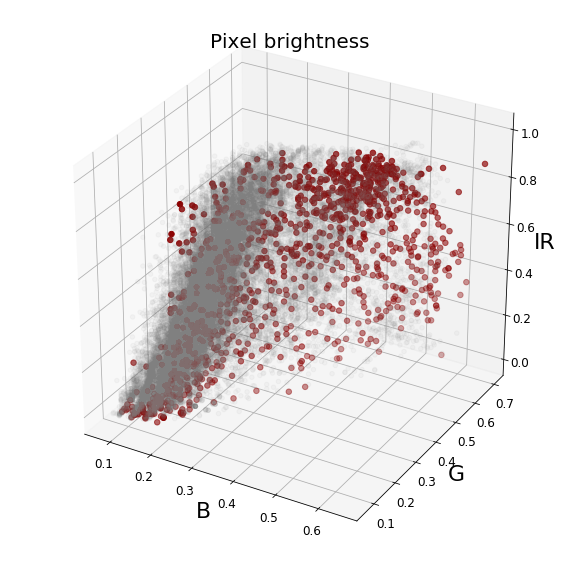

In [5]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# downsample for plot
arr_x_plot = arr_x[::20,:]
arr_y_plot = arr_y[::20]


fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection='3d')
ix = arr_y_plot == 40
ax.scatter(arr_x_plot[ix,0], arr_x_plot[ix,1], arr_x_plot[ix,3], c="gray", alpha=0.05)  # , c=c, marker=m
ix = arr_y_plot == 200
ax.scatter(arr_x_plot[ix,0], arr_x_plot[ix,1], arr_x_plot[ix,3], c="darkred", s=30)  # , c=c, marker=m

ax.set_xlabel('B')
ax.set_ylabel('G')
ax.set_zlabel('IR')
plt.title("Pixel brightness")
plt.savefig(os.path.join(img_out_dir, img_out_fn), orientation='portrait')

#plt.show()
